# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import os
from torch.optim import lr_scheduler
from pathlib import Path
from sklearn.model_selection import KFold

BATCH_SIZE = 32
# For implementation of ReLock
labels_holdout = []
info_holdout = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cuda device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [2]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        size = int(X_batch.shape[1]/ 2)
        antenna1 = X_batch[:,:size]
        antenna2 = X_batch[:,size:]
        y_pred = model(antenna1, antenna2)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [3]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            size = int(X_batch.shape[1]/ 2)
            antenna1 = X_batch[:,:size]
            antenna2 = X_batch[:,size:]

            y_test_pred = model(antenna1, antenna2)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

Ορίζουμε μία κλάση έτσι ώστε το μοντέλο μας να σταματάει νωρίς όταν παρατηρεί ότι το test loss αυξάνεται η μέθοδος αυτή είναι γνωστή και ως early stopping.

In [4]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path

        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            if self.verbose:
                print(f"Validation loss decreased to {val_loss:.6f}. Saving model...")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
    
    def get_best_loss(self):
        return self.best_loss

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [5]:
def train_test_model(epoch: int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     early_stopper = None,
                     device: torch.device = 'cpu',
                     test: bool = True,
                     verbose: bool = True):

    torch.manual_seed(42)
    train_loss_arr = []
    test_loss_arr = []
    
    if(test):
        for epochs in range(epoch):
            # Train for one epoch
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            # Scheduler update
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']

            # Evaluate on test set
            test_loss = test_step(model, test_loader, loss_fn, device)
            test_loss_arr.append(test_loss / len(test_loader))

            # Print progress
            if verbose == True:
                if (epochs % 10 == 0) or (epochs == 0):
                    print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')
                elif epochs + 1 == epoch:
                    print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')

            # Early stopping check
            early_stopper(test_loss_arr[-1], model)
            if early_stopper.early_stop:
                if verbose == True:
                    print(f"Early stopping at epoch {epochs}")
                break

        # Load the best model weights after stopping
        if early_stopper.path is not None:
            model.load_state_dict(torch.load(early_stopper.path, weights_only= True))
            if verbose == True:
                print(f"Loaded best model from {early_stopper.path}")

        return train_loss_arr, test_loss_arr, early_stopper.get_best_loss(), epochs
    else:
        for epochs in range(epoch):
            # Train for one epoch
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            # Scheduler update
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']

            # Print progress
            if verbose == True:
                if (epochs % 10 == 0) or (epochs == 0):
                    print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | lr = {after_lr}')
                elif epochs + 1 == epoch:
                    print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | lr = {after_lr}')
        return train_loss_arr

Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

In [6]:
def eval_model_3d(model: torch.nn.Module, 
                  data_loader: torch.utils.data.DataLoader, 
                  scaler,
                  device: torch.device = 'cpu',
                  verbose=True):

    model.eval()
    model.to(device)
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            size = int(X.shape[1]/ 2)
            antenna1 = X[:,:size]
            antenna2 = X[:,size:]
            y_pred = model(antenna1, antenna2)

            # Move to CPU and collect all predictions and targets
            all_preds.append(y_pred.cpu())
            all_targets.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Reverse scaling
    y_pred_real = scaler.inverse_transform(all_preds)
    y_true_real = scaler.inverse_transform(all_targets)

    # Calculate average Euclidean distance (in cm)
    distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
    mean_distance_error = np.mean(distances)
    std_distance_error = np.std(distances)

    # Plot real data VS predicted in 3D
    if verbose:
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111, projection='3d')

        number_of_points = 20

        # Plot ground truth points
        ax.scatter(
            y_true_real[:number_of_points, 0], 
            y_true_real[:number_of_points, 1], 
            y_true_real[:number_of_points, 2], 
            color='blue', label='Ground Truth', s=100
        )

        # Plot predicted points
        ax.scatter(
            y_pred_real[:number_of_points, 0], 
            y_pred_real[:number_of_points, 1], 
            y_pred_real[:number_of_points, 2], 
            color='red', label='Predicted', s=100
        )

        # Draw lines connecting corresponding points
        for i, (gt, pred) in enumerate(zip(y_true_real[:number_of_points], y_pred_real[:number_of_points])):
            ax.plot(
                [gt[0], pred[0]], 
                [gt[1], pred[1]], 
                [gt[2], pred[2]], 
                color='gray', linestyle='--', linewidth=1
            )
            
            # Calculate the midpoint of the line for placing the text
            mid_x = (gt[0] + pred[0]) / 2
            mid_y = (gt[1] + pred[1]) / 2
            mid_z = (gt[2] + pred[2]) / 2
            
            # Annotate the line with the corresponding distance from the distances array
            ax.text(mid_x, mid_y, mid_z, f'{distances[i]:.2f} cm', fontsize=9, ha='center', va='bottom', color='black',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.3))

        # Add labels and legend
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Ground Truth vs Predicted Points\nMean Distance Error: {mean_distance_error:.2f} cm, Std: {std_distance_error:.2f} cm')
        ax.legend()
        ax.grid(True)

        # Show the plot
        plt.show()

    return {
        "model_name": model.__class__.__name__,
        "mean_distance_error_cm": mean_distance_error.item(),
        "std": std_distance_error.item()
    }

Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [7]:
def plot_results(train_arr, test_arr):
    # Plot the loss curves
    train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss')
    plt.plot(test_arr, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title("Normalized Training Loss")
    plt.grid()
    plt.legend()
    plt.show()

***

## Εισαγωγή δεδομένων

Κάνουμε scale και το Y οπότε σε περίπτωση τυχαίου διανύσματος θα πρέπει να το κάνουμε και αυτό scale, και μετά το output να το επαναφέρουμε.

Έχοντας δοκιμάσει να κανονικοποιήσουμε τα δεδομένα εισόδου σε [-1,1] και τα δεδομένα εξόδου με την χρήση του standardscaler, τα αποτελέσματα είναι **ελαφρώς χειρότερα** από το να κανονικοποιήσουμε και την είσοδο και την έξοδο με τον standard scaler.

Κάνοντας χρήση της μεθόδου [-1,1] τοσο για την είσοδο όσο για την έξοδο τα αποτελέσματα είναι **σαφώς χειρότερα**

Για την ώρα κρατάμε το [-1,1] για την είσοδο και το StandardScaler για την έξοδο.

Ανάλογα με τον ποιον φάκελο θέλουμε να διαβάσουμε αλλάζουμε το νουμεράκι.

In [8]:
# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

parent_dir = os.path.join(parent_dir, '..', 'Experiments', 'Raw_Data_Double_Antenna_0') 


rfid_label = np.load(f"{parent_dir}\\final_labels.npy")
info_tensor = np.load(f"{parent_dir}\\final_tensor.npy")

info_tensor.shape , rfid_label.shape

((2638, 500, 8), (2638, 3))

In [9]:
print(info_tensor[:,:,6])

[[107.3 107.3 107.3 ... 107.3 107.3 107.3]
 [ 63.3  63.3  63.3 ...  63.3  63.3  63.3]
 [107.3 107.3 107.3 ... 107.3 107.3 107.3]
 ...
 [ 63.3  63.3  63.3 ...  63.3  63.3  63.3]
 [107.3 107.3 107.3 ... 107.3 107.3 107.3]
 [152.8 152.8 152.8 ... 152.8 152.8 152.8]]


Ουσιαστικά αναζητούμε τα **Χ και Υ** του RFID TAG, γνωρίζοντας το πως **κινήθηκε** και την μέτρηση της **φάσης** του.

Αποθηκεύουμε σε μεταβλητές τα μεγέθη του input και του output για τα γραμμικά μοντέλα.

In [10]:
output_len = rfid_label.shape[1]
input_len = info_tensor.shape[1] * info_tensor.shape[2]

input_len,output_len

(4000, 3)

In [11]:
def data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size = 32):
    # Compute abs max PER FEATURE on training data
    abs_max = np.abs(X_main).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_main / abs_max  # shape (N_train, 500, 4)
    X_test_norm = X_holdout / abs_max    # shape (N_test, 500, 4)

    # Now reshape for linear model
    X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  # (N_train, 2000)
    X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)     # (N_test, 2000)

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_main_scaled = scaler_Y.fit_transform(y_main)
    y_holdout_scaled = scaler_Y.transform(y_holdout)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_main_tensor = torch.tensor(y_main_scaled, dtype=torch.float32)
    y_holdout_tensor = torch.tensor(y_holdout_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_main_tensor)
    test_data = TensorDataset(X_test_tensor, y_holdout_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

In [12]:
def data_func_cv(input_array, labels, train_idx, val_idx, batch_size=32):
    # Trim into subset
    X_train_raw = input_array[train_idx]
    X_test_raw = input_array[val_idx]
    y_train = labels[train_idx, :]
    y_test = labels[val_idx, :]

    # Compute abs max PER FEATURE on training data
    abs_max = np.abs(X_train_raw).max(axis=(0,1))  # max per feature over (samples, time)

    # Prevent division by zero
    abs_max[abs_max == 0] = 1.0

    # Normalize per feature
    X_train_norm = X_train_raw / abs_max  
    X_test_norm = X_test_raw / abs_max  

    # Now reshape for linear model
    X_train_scaled = X_train_norm.reshape(len(X_train_norm), -1)  
    X_test_scaled = X_test_norm.reshape(len(X_test_norm), -1)   

    # Scale Y with StandardScaler (correct approach)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Dataloaders
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y


***

## Cross Validation 

Η κύρια συνάρτηση, δέχεται όλες τις παραμέτρους του μοντέλου, χωρίζει το dataset σε main και holdout, το main θα χρησιμοποιηθεί για το CV ενώ το holdout για το τελικό evaluation.

Χωρίζει το main dataset σε n_splits subsets , και προπονεί και τεστάρει το μοντέλο σε αυτά τα subsets έτσι ώστε να υπάρχει μία καλύτερη εικόνα των δεδομένων.

Μετά το CV, προπονεί το μοντέλο στο main dataset και το τεστάρει στο holdout που μέχρι τώρα δεν το έχει δει καθόλου το μοντέλο, αντιπροσωπέυοντας την real world case.

In [13]:
def cross_validation(input_array, labels, n_splits, model, model_param, loss_fn, optimizer_1, optimizer_param, scheduler_param, early_stopper_param, epochs, device, verbose = True):
    # Hold out 5% of the data for final validation
    X_main, X_holdout, y_main, y_holdout = train_test_split(
        input_array, labels, test_size=0.05, random_state=42
    )

    ################## FOR PHASE RELOCK ################
    global labels_holdout
    global info_holdout
    labels_holdout = y_holdout
    info_holdout = X_holdout
    ####################################################

    # Initialize KFold
    kf = KFold(n_splits= n_splits, shuffle= True, random_state= 42)

    # Initialize arrays to store losses and epochs
    cv_losses = []
    epoch_array = []

    # Loop over the folds to perform cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_main)):
        
        print(f"Fold {fold_idx + 1}")

        train_loader, test_loader, _ = data_func_cv(X_main, y_main, train_idx, val_idx, batch_size=BATCH_SIZE)
        # Instantiate the model
        model_0 = model(**model_param)

        loss_fn = loss_fn
        optimizer = optimizer_1(model_0.parameters(), **optimizer_param)

        # Initialize the scheduler
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, **scheduler_param)

        # Initialize early stopping
        early_stopper = EarlyStopping(**early_stopper_param)

        # Load the data
        arr1, arr2, best_loss, epoch_stop = train_test_model(epoch = epochs,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= True, verbose = verbose)
        
        if verbose == True:
            plot_results(arr1, arr2)

        cv_losses.append(best_loss)
        epoch_array.append(epoch_stop)
    
    # Evaluate the final model
    train_loader, test_loader, scaler_Y = data_func_eval(X_main, X_holdout, y_main, y_holdout, batch_size=BATCH_SIZE)
    print(f"Cross-Validation finished with mean error across {n_splits} subsets = {np.mean(cv_losses)}, evaluating final model...")

    # Instantiate the model
    final_model = model(**model_param)

    final_optimizer = optimizer_1(final_model.parameters(), **optimizer_param)

    # Initialize the scheduler
    scheduler = lr_scheduler.CosineAnnealingLR(final_optimizer, **scheduler_param)

    # Load the data
    arr1= train_test_model(epoch = np.max(epoch_array),model = final_model, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=final_optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device, test= False, verbose= verbose)

    result = eval_model_3d(model= final_model, data_loader= test_loader, scaler= scaler_Y, verbose= True)
    return result, final_model

***

## Siamese Network

In [14]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(SiameseNetwork, self).__init__()
        
        # Shared feature extractor
        self.shared_network = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units//2),
            nn.LeakyReLU(),
            nn.Linear(in_features= hidden_units//2, out_features= hidden_units),
            nn.LeakyReLU(),
            nn.Linear(in_features= hidden_units, out_features=hidden_units//2 ),   
        )
        
        # Fully connected layers after feature extraction
        self.fc = nn.Sequential(
            nn.Linear(hidden_units//2, hidden_units//4),  # Concatenated features from both antennas
            nn.LeakyReLU(),
            nn.Linear(hidden_units//4, output_size)  # Output x, y (or x, y, z)
        )

    def forward(self, antenna1, antenna2):
        feat1 = self.shared_network(antenna1)
        feat2 = self.shared_network(antenna2)
        
        # Concatenate both embeddings
        combined = torch.max(feat1, feat2)
        
        # Final prediction
        output = self.fc(combined)
        return output


Fold 1


c:\Users\Mooze\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0 | Loss train: 0.849168 | Loss test: 0.768776 | lr = 0.00045071864208380145
Epoch 10 | Loss train: 0.412565 | Loss test: 0.468908 | lr = 0.0008439462855468738
Epoch 20 | Loss train: 0.281552 | Loss test: 0.368601 | lr = 0.0009251128852796987
Epoch 30 | Loss train: 0.214239 | Loss test: 0.301755 | lr = 0.0009561634759386547
Epoch 40 | Loss train: 0.186155 | Loss test: 0.298221 | lr = 0.0009667810012459001
Epoch 50 | Loss train: 0.159764 | Loss test: 0.246146 | lr = 0.0009754589690638924
Epoch 60 | Loss train: 0.140548 | Loss test: 0.234090 | lr = 0.0009809714605672956
Epoch 70 | Loss train: 0.117711 | Loss test: 0.254986 | lr = 0.0009866272053774853
Epoch 80 | Loss train: 0.098640 | Loss test: 0.232507 | lr = 0.0009905966060366085
Epoch 90 | Loss train: 0.098460 | Loss test: 0.228282 | lr = 0.0009906308286045992
Epoch 100 | Loss train: 0.085463 | Loss test: 0.235304 | lr = 0.0009929355164795277
Epoch 110 | Loss train: 0.071214 | Loss test: 0.207944 | lr = 0.0009950913489960055
Ep

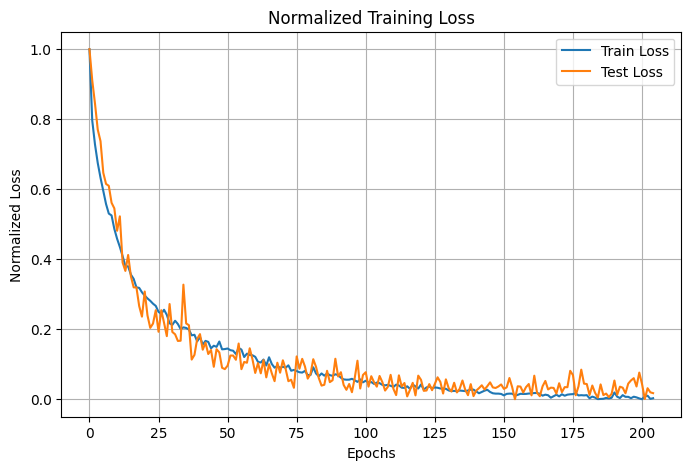

Fold 2


c:\Users\Mooze\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0 | Loss train: 0.833098 | Loss test: 0.672371 | lr = 0.00046639267980349273
Epoch 10 | Loss train: 0.392222 | Loss test: 0.396588 | lr = 0.000858192417942801
Epoch 20 | Loss train: 0.283686 | Loss test: 0.361917 | lr = 0.0009240035804324587
Epoch 30 | Loss train: 0.205502 | Loss test: 0.263180 | lr = 0.0009596174406333195
Epoch 40 | Loss train: 0.171935 | Loss test: 0.232214 | lr = 0.0009716150853864763
Epoch 50 | Loss train: 0.144519 | Loss test: 0.231929 | lr = 0.000979888623494434
Epoch 60 | Loss train: 0.118985 | Loss test: 0.217948 | lr = 0.0009863374950148092
Epoch 70 | Loss train: 0.109636 | Loss test: 0.227005 | lr = 0.0009883919460728845
Epoch 80 | Loss train: 0.097044 | Loss test: 0.195350 | lr = 0.0009908975213304958
Epoch 90 | Loss train: 0.086429 | Loss test: 0.189665 | lr = 0.0009927753670129818
Epoch 100 | Loss train: 0.088885 | Loss test: 0.167473 | lr = 0.0009923599985487224
Epoch 110 | Loss train: 0.070014 | Loss test: 0.154731 | lr = 0.0009952550058057049
Epoc

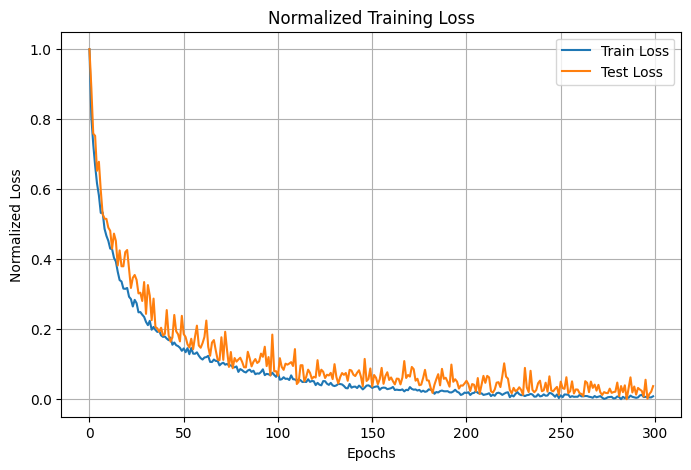

Fold 3


c:\Users\Mooze\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0 | Loss train: 0.834805 | Loss test: 0.731603 | lr = 0.00046472546973228636
Epoch 10 | Loss train: 0.382007 | Loss test: 0.411139 | lr = 0.0008651312864790758
Epoch 20 | Loss train: 0.262293 | Loss test: 0.335616 | lr = 0.0009347839576136955
Epoch 30 | Loss train: 0.203332 | Loss test: 0.380941 | lr = 0.0009604543818742232
Epoch 40 | Loss train: 0.170048 | Loss test: 0.302436 | lr = 0.0009722287940975655
Epoch 50 | Loss train: 0.144906 | Loss test: 0.268390 | lr = 0.0009797815598550225
Epoch 60 | Loss train: 0.126420 | Loss test: 0.254813 | lr = 0.0009845857503636153
Epoch 70 | Loss train: 0.115769 | Loss test: 0.220639 | lr = 0.0009870628823851948
Epoch 80 | Loss train: 0.107218 | Loss test: 0.233747 | lr = 0.000988896570230551
Epoch 90 | Loss train: 0.084286 | Loss test: 0.214880 | lr = 0.0009931284280252557
Epoch 100 | Loss train: 0.080243 | Loss test: 0.210166 | lr = 0.0009937705082403829
Epoch 110 | Loss train: 0.070267 | Loss test: 0.213873 | lr = 0.0009952208230632484
Epo

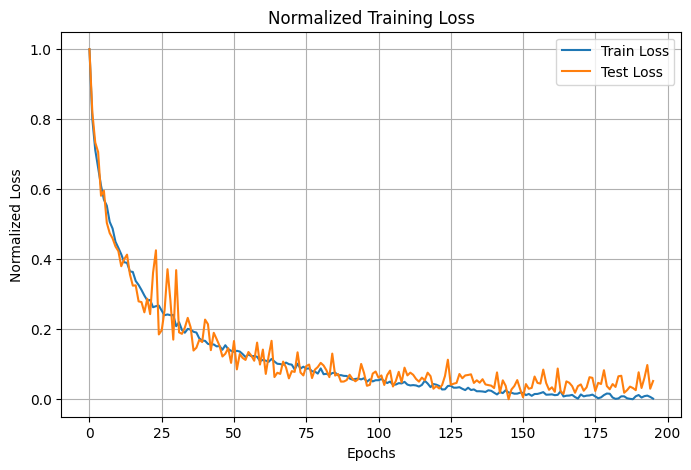

Fold 4


c:\Users\Mooze\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0 | Loss train: 0.838988 | Loss test: 0.722595 | lr = 0.0004606423083406776
Epoch 10 | Loss train: 0.423955 | Loss test: 0.477354 | lr = 0.0008357280501768753
Epoch 20 | Loss train: 0.298392 | Loss test: 0.449050 | lr = 0.0009161564563762171
Epoch 30 | Loss train: 0.233210 | Loss test: 0.307599 | lr = 0.0009482002431190714
Epoch 40 | Loss train: 0.187586 | Loss test: 0.235782 | lr = 0.0009662740319798423
Epoch 50 | Loss train: 0.147089 | Loss test: 0.249276 | lr = 0.0009791721164964249
Epoch 60 | Loss train: 0.120981 | Loss test: 0.207495 | lr = 0.000985877380366354
Epoch 70 | Loss train: 0.107483 | Loss test: 0.210658 | lr = 0.000988841772046794
Epoch 80 | Loss train: 0.093909 | Loss test: 0.206413 | lr = 0.000991474495614462
Epoch 90 | Loss train: 0.083049 | Loss test: 0.202331 | lr = 0.0009933281542864035
Epoch 100 | Loss train: 0.074555 | Loss test: 0.191411 | lr = 0.0009946207996735323
Epoch 110 | Loss train: 0.068835 | Loss test: 0.183261 | lr = 0.0009954132309442296
Epoch 

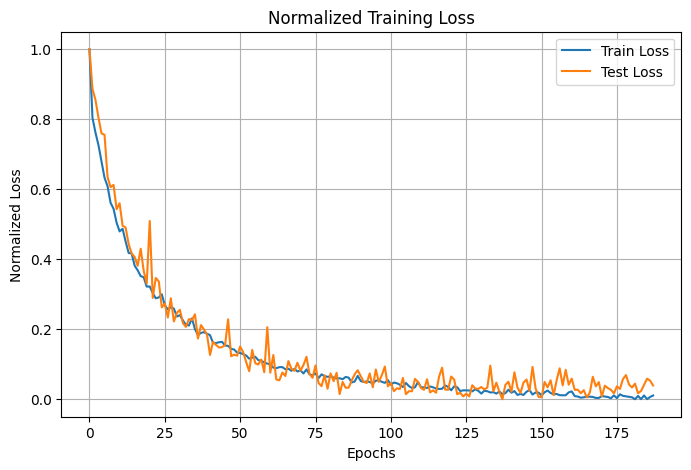

Fold 5


c:\Users\Mooze\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0 | Loss train: 0.854760 | Loss test: 0.692412 | lr = 0.0004452767432779029
Epoch 10 | Loss train: 0.410832 | Loss test: 0.432198 | lr = 0.0008451814174598558
Epoch 20 | Loss train: 0.276640 | Loss test: 0.305567 | lr = 0.0009276382684472807
Epoch 30 | Loss train: 0.225069 | Loss test: 0.286128 | lr = 0.0009516949233855272
Epoch 40 | Loss train: 0.183300 | Loss test: 0.271727 | lr = 0.0009677811131891866
Epoch 50 | Loss train: 0.159062 | Loss test: 0.273267 | lr = 0.00097567234650938
Epoch 60 | Loss train: 0.135144 | Loss test: 0.237079 | lr = 0.0009823981734010767
Epoch 70 | Loss train: 0.102744 | Loss test: 0.238949 | lr = 0.0009898006479797995
Epoch 80 | Loss train: 0.092121 | Loss test: 0.216610 | lr = 0.0009917952526908944
Epoch 90 | Loss train: 0.081075 | Loss test: 0.239989 | lr = 0.0009936408800912417
Epoch 100 | Loss train: 0.078291 | Loss test: 0.237749 | lr = 0.0009940692408276417
Epoch 110 | Loss train: 0.072365 | Loss test: 0.183032 | lr = 0.0009949315746887977
Epoch

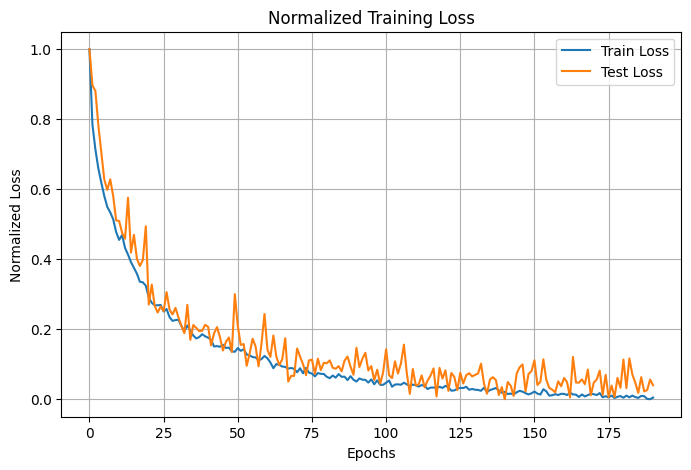

Cross-Validation finished with mean error across 5 subsets = 0.165069121401757, evaluating final model...


c:\Users\Mooze\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0 | Loss train: 0.812446 | lr = 0.0002916645407099572
Epoch 10 | Loss train: 0.409332 | lr = 0.000765792032215067
Epoch 20 | Loss train: 0.273635 | lr = 0.0008901715391238107
Epoch 30 | Loss train: 0.210163 | lr = 0.0009341778449667675
Epoch 40 | Loss train: 0.170713 | lr = 0.0009562321029059199
Epoch 50 | Loss train: 0.151289 | lr = 0.0009655146078514222
Epoch 60 | Loss train: 0.144256 | lr = 0.0009686126061775101
Epoch 70 | Loss train: 0.120801 | lr = 0.0009779191384507724
Epoch 80 | Loss train: 0.101684 | lr = 0.0009843205909701358
Epoch 90 | Loss train: 0.094478 | lr = 0.0009864544774651266
Epoch 100 | Loss train: 0.087768 | lr = 0.000988302660578274
Epoch 110 | Loss train: 0.077939 | lr = 0.0009907681602302277
Epoch 120 | Loss train: 0.070365 | lr = 0.0009924709398116834
Epoch 130 | Loss train: 0.066433 | lr = 0.0009932870049108788
Epoch 140 | Loss train: 0.065562 | lr = 0.0009934615085535974
Epoch 150 | Loss train: 0.058828 | lr = 0.0009947334540819548
Epoch 160 | Loss trai

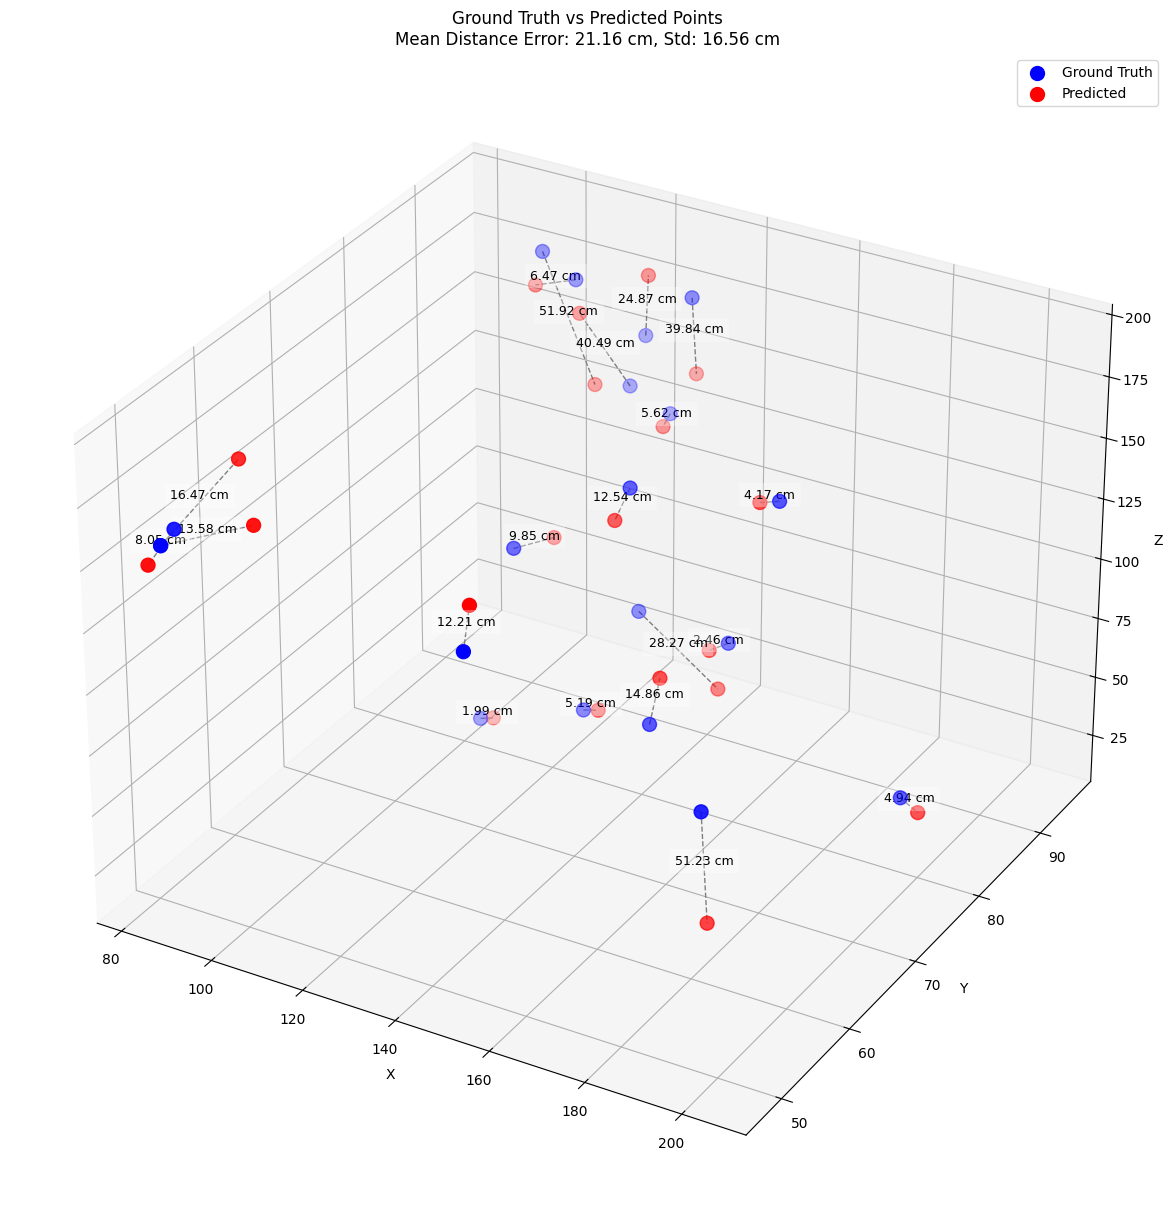

In [15]:
loss_fn = nn.MSELoss()
optim = torch.optim.Adam

num_splits = 5
epoch = 300
model_params = {'input_size': int(input_len/2), 'output_size': output_len}
optimizer_params = {'lr': 1e-3, 'weight_decay': 1e-4}
scheduler_params = {'T_max': 100, 'eta_min': 1e-5}  # For CosineAnnealingLR
early_stop_params = {'patience': 50, 'min_delta': 1e-5, 'verbose': False, 'path': 'temp_model.pth'}

siameseNetwork, trained_model = cross_validation(info_tensor, rfid_label, n_splits=num_splits, model= SiameseNetwork, model_param= model_params, loss_fn= loss_fn, optimizer_1= optim, optimizer_param= optimizer_params, scheduler_param= scheduler_params, early_stopper_param= early_stop_params, epochs= epoch, device=device)

In [16]:
trained_model(torch.Tensor(info_tensor[0,:,4:].reshape(2000,-1).T) , torch.Tensor(info_tensor[0,:,:4].reshape(2000,-1).T))

tensor([[734.6181,  29.6508,  80.1922]], grad_fn=<AddmmBackward0>)

In [17]:
trained_model(torch.Tensor(info_tensor[0,:,:4].reshape(2000,-1).T) , torch.Tensor(info_tensor[0,:,4:].reshape(2000,-1).T))

tensor([[734.6181,  29.6508,  80.1922]], grad_fn=<AddmmBackward0>)

In [18]:
rfid_label[0]

array([117.81756601,  74.67164219,   8.9       ])

Η απόκλιση ευθύνεται στο ότι η είσοδος δεν είναι scaled whatever

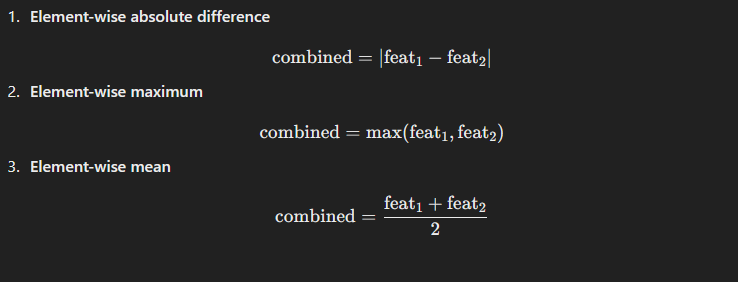